# Legal Opinion Classification with VOCAB BERT

This notebook runs Judgements Classification Task using vocab-bert-medium Model.

**vocab-bert-medium** was developed by feeding bert-medium with specialized legal vocabulary.

### Requirements: 
*   Notebook required authentication with the google drive account containing pretrained models and datasets. 

*   Make sure that pretrained Models and Datasets are available in the drive authenticated.

*   Paths can be modified in cell <a href='#scrollTo=m55DLVVe9pLa'>[this cell]</a> for Dataset and <a href='#scrollTo=E7Mj-0ne--5t'>[this cell]</a> for pretrained Models to direct the notebook to pickup the required resources correctly. 

*   Datasets and Models can be requested (if not accessible) from Cells in their respective sections in this notebook.

This notebook was prepared on Google Colaboratory, and run on Google Compute Engine Backend (GPU). 

## Setup

Install [the Transformers library](https://huggingface.co/transformers/) by Hugging Face

In [1]:
#cleanup from a possible previos execution
!rm -rf legal-bert*
!rm -rf bert*
!rm -f judgement*
!rm -f best_model*

In [2]:
!pip install -q -U watermark

In [3]:
!pip install -qq transformers

     |████████████████████████████████| 1.3MB 19.9MB/s 
     |████████████████████████████████| 2.9MB 50.2MB/s 
     |████████████████████████████████| 1.1MB 52.7MB/s 
     |████████████████████████████████| 890kB 51.9MB/s 


In [4]:
%reload_ext watermark
%watermark -v -p numpy,pandas,torch,transformers

CPython 3.6.9
IPython 5.5.0

numpy 1.18.5
pandas 1.1.4
torch 1.7.0+cu101
transformers 3.5.0


In [5]:
#@title Imports, Setup & Config
import transformers
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
import torch

import os

import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
from textwrap import wrap

from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)

HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 12, 8

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

## Data Exploration



**Mount Drive and Copy Judgement Data**

Need access to this dataset? Request via [email](mailto:khan06@ads.uni-passau.de?subject=Requesting%20Access%20to%20Judgement%20Set&body=I%20need%20access%20to%20following%20Dataset%3A%0D%0Ahttps%3A%2F%2Fdrive.google.com%2Ffile%2Fd%2F1_ZoKro8G43PLqLN_fK_JXff1USz-pr4b%2Fview%3Fusp%3Dsharing%0D%0A)

In [6]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [7]:
INPUT_DATASET = "judgements_dataset.zip"
#copy judgements data from drive
!cp /gdrive/My\ Drive/Master\ Thesis/Master_Thesis-Comparing_the_Performance_of_NLP_Toolkits_and_Evaluation_measures_in_Legal_tech/Datasets/classification_datasets/20k_judgements.zip $INPUT_DATASET
#extract the judgements data
!unzip $INPUT_DATASET

Archive:  judgements_dataset.zip
  inflating: judgement_type_dissent.tsv  
  inflating: judgement_type_majority.tsv  


In [8]:
#create the list of available files from dataset.
data_files = ["judgement_type_dissent.tsv", "judgement_type_majority.tsv", "judgement_type_concurrence.tsv"]
data_files = [f for f in data_files if os.path.exists(f)]

#get classes names from the list of data files.
class_names = [judgement_class.split(".")[0].split("_")[-1] for judgement_class in data_files]
print("Data Files: "+str(data_files))
print("Classes: "+str(class_names))

Data Files: ['judgement_type_dissent.tsv', 'judgement_type_majority.tsv']
Classes: ['dissent', 'majority']


In [9]:
#method for reading the judgements from input files passed in arguments
def getData(files, file_limit=0):
  data = {}
  data["id"] = []
  data["sentence"] = []
  data["label"] = []
  judgement_data = pd.DataFrame.from_dict(data) # initialize an empty dataframe
  
  for file in files:
    print(file)
    df = pd.read_csv(file, '\t')
    if file_limit>0:
      df = df.sample(frac=1.0).reset_index(drop=True)
      df = df[0:file_limit]
      print(df.shape)
    judgement_data = pd.concat([judgement_data, df]).reset_index(drop=True)
  judgement_data['id'] = judgement_data['id'].astype(int).astype(str)
  judgement_data = judgement_data.sample(frac=1.0).reset_index(drop=True)
  return judgement_data

#read the opinions data into a dataframe
judgements_data = getData(data_files,0)

#shuffle the data to mix up the majority and dissent judgements
judgements_data=judgements_data.sample(frac=1.0).reset_index(drop=True)

judgements_data.head()

judgement_type_dissent.tsv
judgement_type_majority.tsv


id                                           sentence     label
0  4336  The court s opinion correctly states that a su...   dissent
1  9960  Defendant s second point relating to the defen...  majority
2  9549  The improbable story told by Brooks, the filli...   dissent
3  3883  After losing on his appeal from a conviction f...  majority
4  1659  The act of the defendant in erecting the fence...   dissent

In [10]:
label_counts = judgements_data.label.value_counts()
label_counts

dissent     9995
majority    9932
Name: label, dtype: int64

In [11]:
#Let's tag the labels with their respective numeric id
judgement_class2idx = {}
# i = 0
for i, judgement_class in enumerate(label_counts.iteritems()):
    judgement_class2idx[judgement_class[0]] = i
#these are the classes with their int labels which we want to predict
judgement_class2idx

{'dissent': 0, 'majority': 1}

In [12]:
#just reversing keys and values
judgement_class2name={judgement_class2idx[key] : key for key in judgement_class2idx.keys()}

In [13]:
#Let's replace the class labels with their respectie tag ids using cite_class2idx
for key in judgement_class2idx.keys():
  judgements_data.loc[(judgements_data.label == key),'label']=judgement_class2idx[key]

In [14]:
#see the difference in the column cite_class
judgements_data.head(10)

id                                           sentence label
0  4336  The court s opinion correctly states that a su...     0
1  9960  Defendant s second point relating to the defen...     1
2  9549  The improbable story told by Brooks, the filli...     0
3  3883  After losing on his appeal from a conviction f...     1
4  1659  The act of the defendant in erecting the fence...     0
5  3353  The question that comes to my mind is, if the ...     0
6  7351  This was done pursuant to U.S.C. Section requi...     1
7  1497  Following the venue objection, the trial judge...     0
8  2319  Respondent Appellant Patty Zemke Wife appeals ...     1
9  4846  The appellant, MIC d b a Burger King, offered ...     0

We have about 10k examples. Let's check for missing values:

In [15]:
judgements_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19927 entries, 0 to 19926
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        19927 non-null  object
 1   sentence  19927 non-null  object
 2   label     19927 non-null  object
dtypes: object(3)
memory usage: 467.2+ KB


In [16]:
class_names = ['dissent', 'majority'] 

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


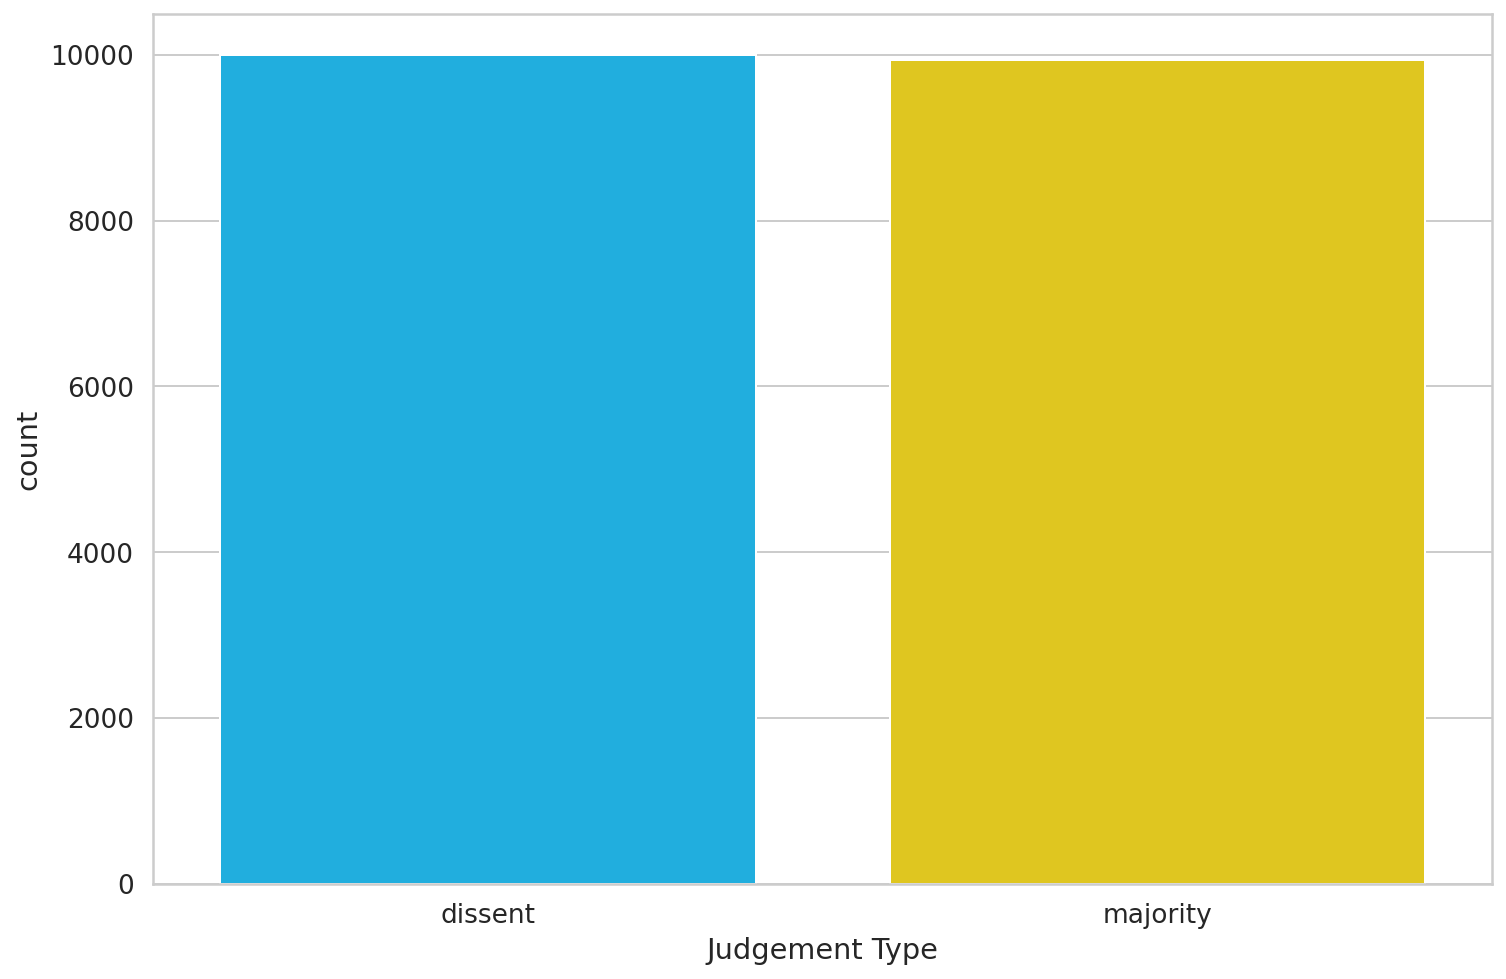

In [17]:
ax = sns.countplot(judgements_data.label)
plt.xlabel('Judgement Type')
ax.set_xticklabels(class_names);

## Data Preprocessing




## Choose a Pretrained BERT Model

Need access to a Model? Request via [email](mailto:khan06@ads.uni-passau.de?subject=Requesting%20Pretrained%20Legal%20Bert%20Models&body=I%20need%20access%20to%20the%20Bert%20Models%2C%20pretrained%20on%20Legal%20Data.)

In [19]:
#@title Choose BERTs Model to run Judgement Classification
BERT_MODEL = "legal-vocab-bert-medium" #@param ["bert-base-cased", "bert-medium", "legal-bert-medium", "vocab-bert-medium", "legal-vocab-bert-medium"]

#selecting the model: The dictionary contains Models and path to their source.
MODELS = {
    "bert-base-cased" : "bert-base-cased",
    "bert-medium" : "/gdrive/My\ Drive/Master\ Thesis/Master_Thesis-Comparing_the_Performance_of_NLP_Toolkits_and_Evaluation_measures_in_Legal_tech/Models/Pytorch_Models/Bert_Medium/",
    "legal-bert-medium" : "/gdrive/My\ Drive/Master\ Thesis/Master_Thesis-Comparing_the_Performance_of_NLP_Toolkits_and_Evaluation_measures_in_Legal_tech/Models/Pytorch_Models/Bert_Medium_Legal/",
    "vocab-bert-medium" : "/gdrive/My\ Drive/Master\ Thesis/Master_Thesis-Comparing_the_Performance_of_NLP_Toolkits_and_Evaluation_measures_in_Legal_tech/Models/Pytorch_Models/Vocab_Bert_Medium/",
    "legal-vocab-bert-medium" : "/gdrive/My\ Drive/Master\ Thesis/Master_Thesis-Comparing_the_Performance_of_NLP_Toolkits_and_Evaluation_measures_in_Legal_tech/Models/Pytorch_Models/Vocab_Bert_Medium_Legal/",
}

if BERT_MODEL != "bert-base-cased": #bert-base-cased can be downloaded from transformer's repository, copy from gdrive if it is our own model
  from google.colab import drive
  drive.mount('/gdrive', force_remount=True)
  !mkdir $BERT_MODEL
  _model_path = MODELS[BERT_MODEL]
  !cp $_model_path/* $BERT_MODEL

#set the model name, it will either be a model from transformer's repository, or the directory name containing the model we selected and copied to from the gdrive
PRE_TRAINED_MODEL_NAME = BERT_MODEL

print("Using model: "+str(BERT_MODEL))

Mounted at /gdrive
Using model: vocab-bert-medium-st


Let's load a pre-trained [BertTokenizer](https://huggingface.co/transformers/model_doc/bert.html#berttokenizer):

In [20]:
tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

In [21]:
#notice the changes in tokenizer's length with the change of bert model. Model fed with specialized legal vocab would have a bigger tokenizer length.
len(tokenizer)

31077


### Choosing Sequence Length


Most of the Judgements seem to contain less than 256 tokens. Choosing a longer sequence length would required reducing batch size, slowing down the progress.

In [22]:
MAX_LEN = 256

Preparing a pytorch dataset.

In [23]:
class JudgementsDataset(Dataset):

  def __init__(self, opinions, targets, tokenizer, max_len):
    self.opinions = opinions
    self.targets = targets
    self.tokenizer = tokenizer
    self.max_len = max_len
  
  def __len__(self):
    return len(self.opinions)
  
  def __getitem__(self, item):
    opinions = str(self.opinions[item])
    target = self.targets[item]

    encoding = self.tokenizer.encode_plus(
      opinions,
      add_special_tokens=True,
      max_length=self.max_len,
      return_token_type_ids=False,
      # pad_to_max_length=True,
      padding='max_length',
      # max_length=128,
      return_attention_mask=True,
      return_tensors='pt',
      truncation=True
    )

    return {
      'opinions_text': opinions,
      'input_ids': encoding['input_ids'].flatten(),
      'attention_mask': encoding['attention_mask'].flatten(),
      'targets': torch.tensor(target, dtype=torch.long)
    }

Let's split the data:

In [24]:
df_train, df_test = train_test_split(judgements_data, test_size=0.3, random_state=RANDOM_SEED)
df_val, df_test = train_test_split(df_test, test_size=0.5, random_state=RANDOM_SEED)

In [25]:
df_train.shape, df_val.shape, df_test.shape

((13948, 3), (2989, 3), (2990, 3))

We also need to create a couple of data loaders. Here's a helper function to do it:

In [26]:
def create_data_loader(df, tokenizer, max_len, batch_size):
  ds = JudgementsDataset(
    opinions=df.sentence.to_numpy(),
    targets=df.label.to_numpy(),
    tokenizer=tokenizer,
    max_len=max_len
  )

  return DataLoader(
    ds,
    batch_size=batch_size,
    num_workers=4
  )

In [27]:
BATCH_SIZE = 16 #this is the optimum batch size for the selected sequence length, making is bigger would make us run out of memory, also compromise accuracy, and making is smaller would slow down the progress significantly.

train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)

Let's have a look at an example batch from our training data loader:

In [28]:
data = next(iter(train_data_loader))
data.keys()

dict_keys(['opinions_text', 'input_ids', 'attention_mask', 'targets'])

In [29]:
print(data['input_ids'].shape)
print(data['attention_mask'].shape)
print(data['targets'].shape)

torch.Size([16, 256])
torch.Size([16, 256])
torch.Size([16])


## Judgements Classification with BERT

We create a custom classifier for judgements that uses the basic [BertModel](https://huggingface.co/transformers/model_doc/bert.html#bertmodel)

In [30]:
class JudgementClassifier(nn.Module):

  def __init__(self, n_classes):
    super(JudgementClassifier, self).__init__()
    self.bert = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)
    self.drop = nn.Dropout(p=0.3)
    self.out = nn.Linear(self.bert.config.hidden_size, n_classes)
  
  def forward(self, input_ids, attention_mask):
    _, pooled_output = self.bert(
      input_ids=input_ids,
      attention_mask=attention_mask
    )
    output = self.drop(pooled_output)
    return self.out(output)

Let's create an instance  of our Judgement Classifier and move it to the GPU:

In [31]:
model = JudgementClassifier(len(class_names))
model = model.to(device)

We'll move the example batch of our training data to the GPU:

In [32]:
input_ids = data['input_ids'].to(device)
attention_mask = data['attention_mask'].to(device)

print(input_ids.shape) # batch size x seq length
print(attention_mask.shape) # batch size x seq length

torch.Size([16, 256])
torch.Size([16, 256])


To get the predicted probabilities from our trained model, we'll apply the softmax function to the outputs:

In [33]:
F.softmax(model(input_ids, attention_mask), dim=1)

tensor([[0.5818, 0.4182],
        [0.5047, 0.4953],
        [0.4893, 0.5107],
        [0.6528, 0.3472],
        [0.4679, 0.5321],
        [0.5110, 0.4890],
        [0.5047, 0.4953],
        [0.5873, 0.4127],
        [0.5008, 0.4992],
        [0.5336, 0.4664],
        [0.4445, 0.5555],
        [0.5565, 0.4435],
        [0.7221, 0.2779],
        [0.5243, 0.4757],
        [0.3642, 0.6358],
        [0.5178, 0.4822]], device='cuda:0', grad_fn=<SoftmaxBackward>)

### Training

To reproduce the training procedure from the BERT paper, we'll use the [AdamW](https://huggingface.co/transformers/main_classes/optimizer_schedules.html#adamw) optimizer provided by Hugging Face. It corrects weight decay, so it's similar to the original paper. We'll also use a linear scheduler with no warmup steps:

In [34]:
EPOCHS = 10

optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)
total_steps = len(train_data_loader) * EPOCHS

scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)

loss_fn = nn.CrossEntropyLoss().to(device)

Selected hyperparameters for fine-tuning:

- Batch size: 16
- Learning rate (Adam): 2e-5
- Number of epochs: 10

Let's continue with writing a helper function for training our model for one epoch:

In [35]:
def train_epoch(
  model, 
  data_loader, 
  loss_fn, 
  optimizer, 
  device, 
  scheduler, 
  n_examples
):
  model = model.train()

  losses = []
  correct_predictions = 0
  
  for d in data_loader:
    input_ids = d["input_ids"].to(device)
    attention_mask = d["attention_mask"].to(device)
    targets = d["targets"].to(device)

    outputs = model(
      input_ids=input_ids,
      attention_mask=attention_mask
    )

    _, preds = torch.max(outputs, dim=1)
    loss = loss_fn(outputs, targets)

    correct_predictions += torch.sum(preds == targets)
    losses.append(loss.item())

    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    optimizer.step()
    scheduler.step()
    optimizer.zero_grad()

  return correct_predictions.double() / n_examples, np.mean(losses)

Training the model should look familiar, except for two things. The scheduler gets called every time a batch is fed to the model. We're avoiding exploding gradients by clipping the gradients of the model using [clip_grad_norm_](https://pytorch.org/docs/stable/nn.html#clip-grad-norm).

Let's write another one that helps us evaluate the model on a given data loader:

In [36]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
  model = model.eval()

  losses = []
  correct_predictions = 0

  with torch.no_grad():
    for d in data_loader:
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)

      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)

      loss = loss_fn(outputs, targets)

      correct_predictions += torch.sum(preds == targets)
      losses.append(loss.item())
  return correct_predictions.double() / n_examples, np.mean(losses)

 Using those two, we can write our training loop.

In [37]:
%%time

history = defaultdict(list)
best_accuracy = 0

for epoch in range(EPOCHS):

  print(f'Epoch {epoch + 1}/{EPOCHS}')
  print('-' * 10)

  train_acc, train_loss = train_epoch(
    model,
    train_data_loader,    
    loss_fn, 
    optimizer, 
    device, 
    scheduler, 
    len(df_train)
  )

  print(f'Train loss {train_loss} accuracy {train_acc}')

  val_acc, val_loss = eval_model(
    model,
    val_data_loader,
    loss_fn, 
    device, 
    len(df_val)
  )

  print(f'Val   loss {val_loss} accuracy {val_acc}')
  print()

  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)
  history['val_acc'].append(val_acc)
  history['val_loss'].append(val_loss)

  if val_acc > best_accuracy:
    best_accuracy = val_acc

  torch.save(model.state_dict(), 'best_model_state_'+str(epoch)+'.bin')
  

Epoch 1/10
----------
Train loss 0.24623639859769647 accuracy 0.9037854889589905
Val   loss 0.2123452379196424 accuracy 0.934091669454667

Epoch 2/10
----------
Train loss 0.15083586523301873 accuracy 0.9533266418124462
Val   loss 0.26334763686238033 accuracy 0.9330879892940782

Epoch 3/10
----------
Train loss 0.0991843250018615 accuracy 0.9723257814740464
Val   loss 0.3119896821297 accuracy 0.9327534292405486

Epoch 4/10
----------
Train loss 0.06858202853812002 accuracy 0.9828649268712359
Val   loss 0.3446419153430681 accuracy 0.9367681498829039

Epoch 5/10
----------
Train loss 0.04198626236038012 accuracy 0.9905362776025236
Val   loss 0.38574469172811937 accuracy 0.9327534292405486

Epoch 6/10
----------
Train loss 0.029588541447408533 accuracy 0.9936191568683682
Val   loss 0.4094931086015459 accuracy 0.9314151890264302

Epoch 7/10
----------
Train loss 0.02162444764037091 accuracy 0.9954115285345568
Val   loss 0.44768009216932114 accuracy 0.9327534292405486

Epoch 8/10
----------

Plotting the Training vs Validation accuracy

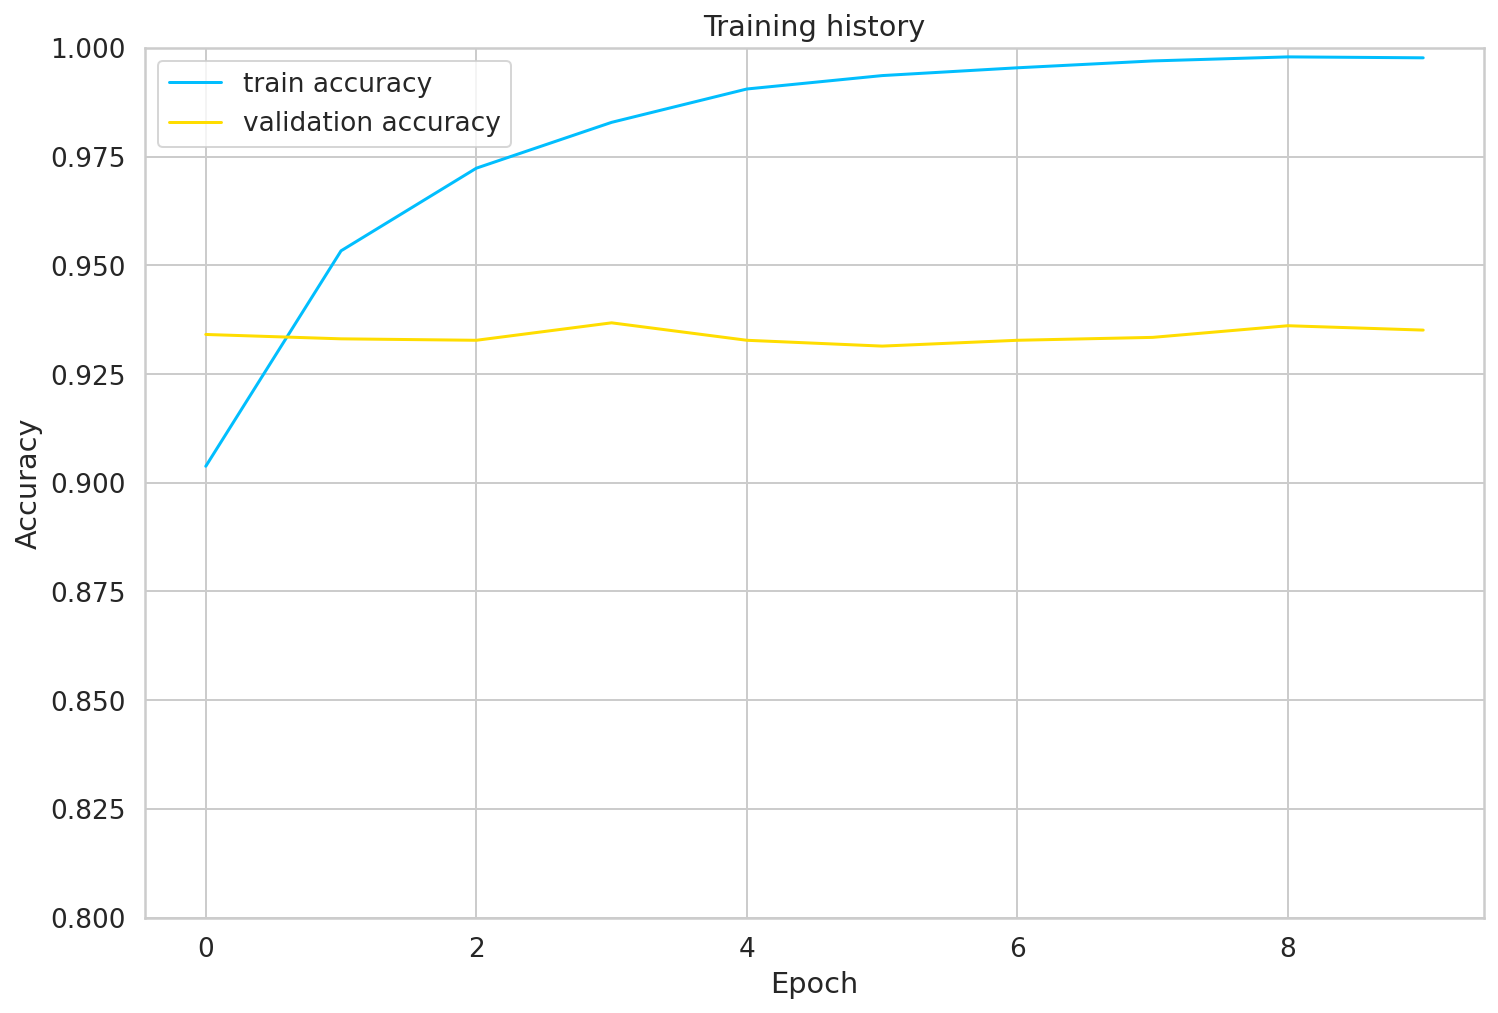

In [38]:
plt.plot(history['train_acc'], label='train accuracy')
plt.plot(history['val_acc'], label='validation accuracy')

plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([.8, 1]);

## Evaluation

Let's findout accuracy on the test dataset by our best Model.

In [39]:
acurracies = []

In [40]:
best_model = "0"
best_accuracy = 0
for model_v in range(10):
  model = JudgementClassifier(len(class_names))
  model.load_state_dict(torch.load('best_model_state_'+str(model_v)+'.bin'))
  model = model.to(device)

  test_acc, _ = eval_model(
    model,
    test_data_loader,
    loss_fn,
    device,
    len(df_test)
  )
  curr_acc = test_acc.item()
  acurracies.append(curr_acc)
  if curr_acc > best_accuracy:
    best_accuracy = curr_acc
    best_model = str(model_v)
print("Best Model: "+str(model_v))
print("Best Accuracy: "+str(best_accuracy))

Best Model: 9
Best Accuracy: 0.9434782608695652


In [41]:
#avg
sum(acurracies)/10

0.9410702341137125

In [42]:
acurracies

[0.9394648829431438,
 0.94314381270903,
 0.940133779264214,
 0.940133779264214,
 0.9434782608695652,
 0.9421404682274247,
 0.9394648829431438,
 0.9404682274247491,
 0.9397993311036789,
 0.9424749163879598]

In [43]:
#should be the same as best_accuracy
max(acurracies)

0.9434782608695652

In [44]:

model = JudgementClassifier(len(class_names))
model.load_state_dict(torch.load('best_model_state_'+best_model+'.bin'))
model = model.to(device)

In [45]:
test_acc, _ = eval_model(
  model,
  test_data_loader,
  loss_fn,
  device,
  len(df_test)
)

test_acc.item()


0.9434782608695652

We'll define a helper function to get the predictions from our model:

In [46]:
def get_predictions(model, data_loader):
  model = model.eval()
  
  judgement_texts = []
  predictions = []
  prediction_probs = []
  real_values = []

  with torch.no_grad():
    for d in data_loader:

      texts = d["opinions_text"]
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)

      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)

      probs = F.softmax(outputs, dim=1)

      judgement_texts.extend(texts)
      predictions.extend(preds)
      prediction_probs.extend(probs)
      real_values.extend(targets)

  predictions = torch.stack(predictions).cpu()
  prediction_probs = torch.stack(prediction_probs).cpu()
  real_values = torch.stack(real_values).cpu()
  return judgement_texts, predictions, prediction_probs, real_values

In [47]:
y_judgement_texts, y_pred, y_pred_probs, y_test = get_predictions(
  model,
  test_data_loader
)

Let's have a look at the classification report

In [48]:
print(classification_report(y_test, y_pred, target_names=class_names, digits=4))

              precision    recall  f1-score   support

     dissent     0.9472    0.9402    0.9437      1506
    majority     0.9398    0.9468    0.9433      1484

    accuracy                         0.9435      2990
   macro avg     0.9435    0.9435    0.9435      2990
weighted avg     0.9435    0.9435    0.9435      2990



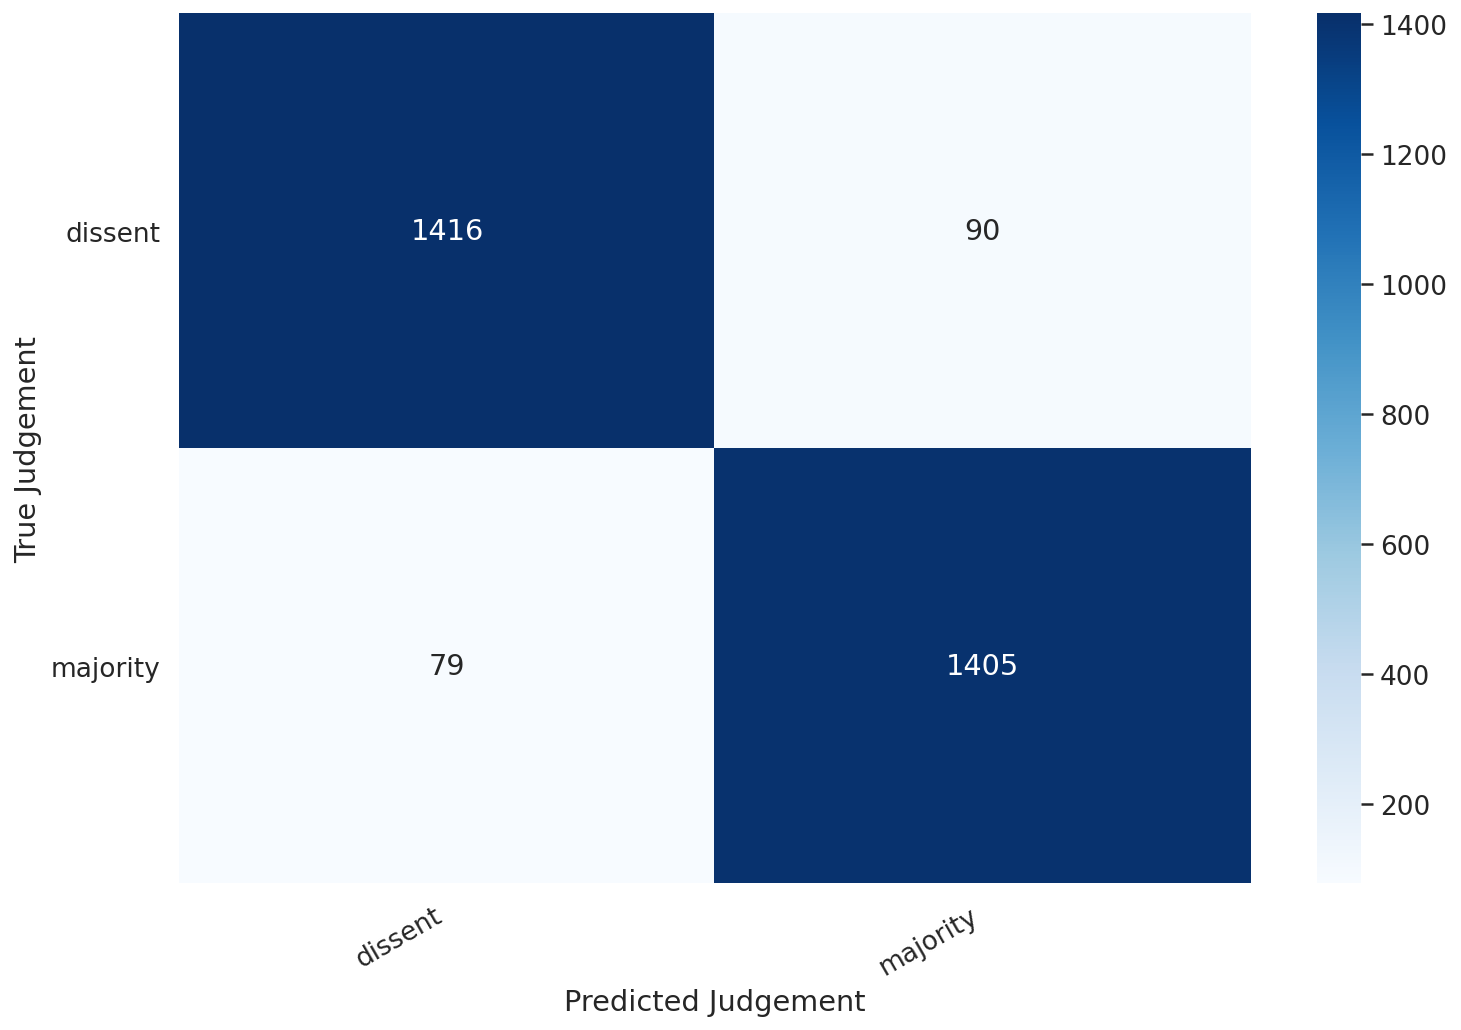

In [49]:
#View the Classification Matrix
def show_confusion_matrix(confusion_matrix):
  hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
  plt.ylabel('True Judgement')
  plt.xlabel('Predicted Judgement');

cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
show_confusion_matrix(df_cm)

### Predicting on Raw Text

Let's use our model to predict the judgement class of some raw text:

In [50]:
judgement_text = "At a rehearing on Defendant s motion to suppress evidence of the stop on the no headlights violation, the trial court suppressed the evidence, directed a verdict, and declared a mistrial on the other charges.. I dissent because the trial court incorrectly concluded that Deputy Jiles contradicted himself and should therefore not be believed.. The trial court concluded, at an earlier hearing, that the evidence of the no headlight violation should not be suppressed.. I therefore conclude that, considering the totality of the circumstances, Deputy Jiles had reasonable suspicion to stop Defendant s vehicle."

We have to use the tokenizer to encode the text:

In [51]:
encoded_judgement = tokenizer.encode_plus(
  judgement_text,
  max_length=MAX_LEN,
  add_special_tokens=True,
  return_token_type_ids=False,
  pad_to_max_length=True,
  return_attention_mask=True,
  return_tensors='pt',
)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:2022: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


Let's get the predictions from our model:

In [52]:
input_ids = encoded_judgement['input_ids'].to(device)
attention_mask = encoded_judgement['attention_mask'].to(device)

output = model(input_ids, attention_mask)
_, prediction = torch.max(output, dim=1)

print(f'Judgment text: {judgement_text}')
print(f'Judgement Class  : {class_names[prediction]}')

Judgment text: At a rehearing on Defendant s motion to suppress evidence of the stop on the no headlights violation, the trial court suppressed the evidence, directed a verdict, and declared a mistrial on the other charges.. I dissent because the trial court incorrectly concluded that Deputy Jiles contradicted himself and should therefore not be believed.. The trial court concluded, at an earlier hearing, that the evidence of the no headlight violation should not be suppressed.. I therefore conclude that, considering the totality of the circumstances, Deputy Jiles had reasonable suspicion to stop Defendant s vehicle.
Judgement Class  : dissent
